In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('Data/retail_store_inventory.csv')

df


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2024-01-01,S005,P0016,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter
73096,2024-01-01,S005,P0017,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn
73097,2024-01-01,S005,P0018,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter
73098,2024-01-01,S005,P0019,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring


In [2]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand Forecast     73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

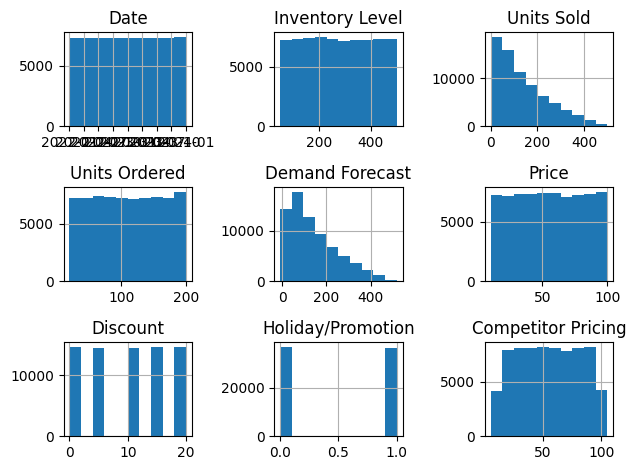

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist()
plt.xlabel("")
plt.tight_layout()
plt.show()

In [4]:
feature = ['Category', 'Region', 'Weather Condition', 'Seasonality']

for feat in feature:
    print(f"Feature: {feat}: {df[feat].unique()}\n")

Feature: Category: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']

Feature: Region: ['North' 'South' 'West' 'East']

Feature: Weather Condition: ['Rainy' 'Sunny' 'Cloudy' 'Snowy']

Feature: Seasonality: ['Autumn' 'Summer' 'Winter' 'Spring']



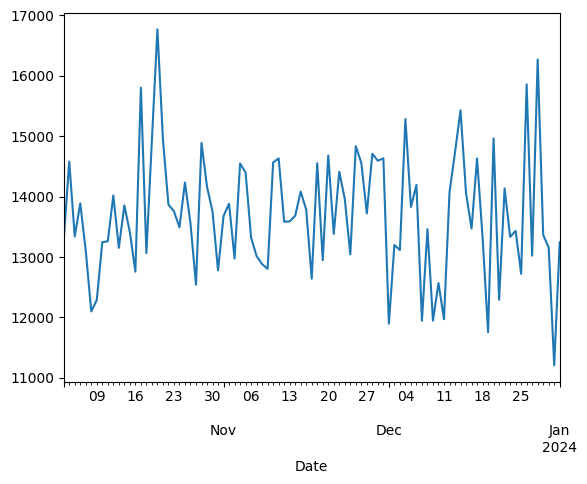

In [5]:
cut_off = df['Date'].max() - pd.Timedelta(days = 90)

test_df = df[df['Date'] >= cut_off].groupby(by='Date')['Units Sold'].sum()

test_df.plot(kind= 'line')

plt.show()

- One-hot encode: `Category`, `Region`
- Label encode: `Weather Condition`, `Store ID`, `Product ID`
- Cylindrical encode: `Seasonality`, `Day_sin` and `Day_cos`

In [6]:
season_map = {'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter' : 3, }

df['day'] = df['Date'].dt.day_of_week
df['is_weekend'] = df['day'].isin([5,6]).astype(int)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)


df['Seasonality'] = df['Seasonality'].map(season_map)
df['season_sin'] = np.sin(2 * np.pi * df['Seasonality'] / 4)
df['season_cos'] = np.cos(2 * np.pi * df['Seasonality'] / 4)

In [7]:
df['Units sold_lag'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(7)
df['rolling_mean_7'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(
    lambda x: x.shift(1).rolling(window= 7).mean()
)
df = df.fillna(0)

df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality', 'day', 'is_weekend', 'day_sin',
       'day_cos', 'season_sin', 'season_cos', 'Units sold_lag',
       'rolling_mean_7'],
      dtype='object')

In [8]:
split = int(len(df) * 0.8)

train, test = df.iloc[:split], df.iloc[split:]

y_train, y_test = train['Units Sold'], test['Units Sold']

cols_to_drop = ['Units Sold', 'Units Ordered', 'is_weekend',
                'Seasonality', 'day', 'Date','Demand Forecast',
                'Store ID', 'Product ID', 'Region', 'Competitor Pricing',
                'rolling_mean_7',]

X_train, X_test = train.drop(columns=cols_to_drop), test.drop(columns= cols_to_drop)

X_train.columns

Index(['Category', 'Inventory Level', 'Price', 'Discount', 'Weather Condition',
       'Holiday/Promotion', 'day_sin', 'day_cos', 'season_sin', 'season_cos',
       'Units sold_lag'],
      dtype='object')

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor


preprocessing = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown= 'ignore'), ['Category', #'Region'
                                                    'Weather Condition']), 
    #('oe', OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value= -1), ['Store ID', 'Product ID']),
    ('scaler', StandardScaler(),
     ['Inventory Level', 
      'Price', 
      'Discount', 'Units sold_lag'])
])


xgb = Pipeline([
    ('preprocess', preprocessing),
    ('xgb', XGBRegressor(random_state = 8))
])

base = Pipeline([
    ('preprocess', preprocessing),
    ('ridge', Ridge())  
])


xgb.fit(X_train, y_train)
base.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

y_xgb = xgb.predict(X_test)
y_base = base.predict(X_test)

print("Base")
print(f"MAE: {mean_absolute_error(y_true= y_test, y_pred= y_base):.4f}")
print(f"R2: {r2_score(y_true= y_test, y_pred= y_base):.4f}")

print("XGBoost")
print(f"MAE: {mean_absolute_error(y_true= y_test, y_pred= y_xgb):.4}f")
print(f"R2: {r2_score(y_true= y_test, y_pred= y_xgb):.4f}")



Base
MAE: 68.6535
R2: 0.3446
XGBoost
MAE: 69.78f
R2: 0.3093


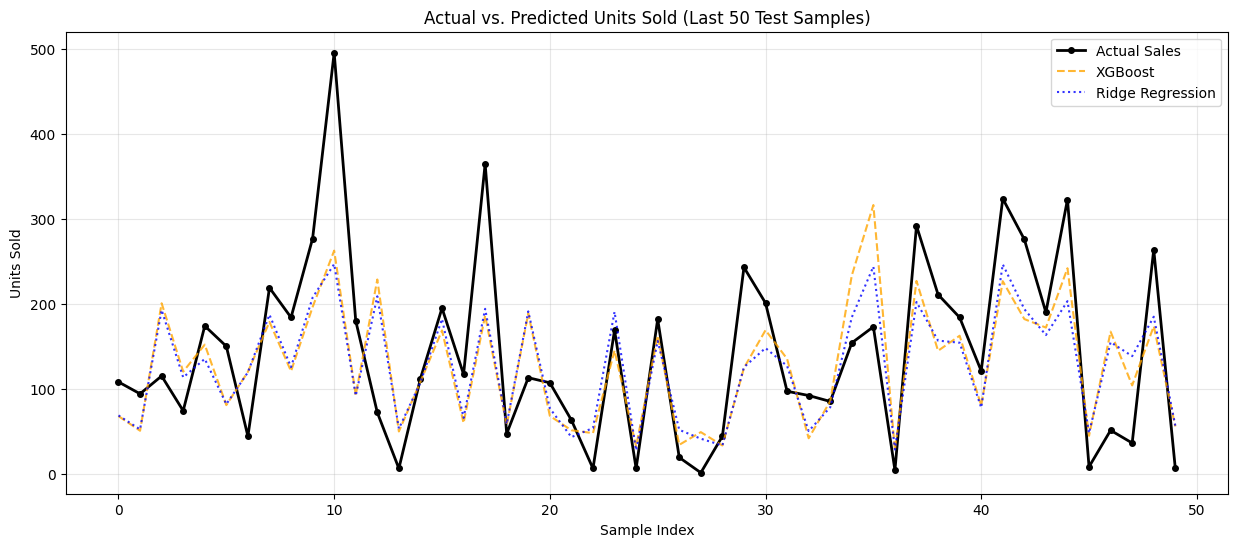

In [11]:
import matplotlib.pyplot as plt

# Create a plotting dataframe
plt_df = X_test.copy()
plt_df['Actual'] = y_test
plt_df['XGB_Pred'] = y_xgb
plt_df['Ridge_Pred'] = y_base

# Take a slice to keep the plot readable
slice_df = plt_df.tail(50).reset_index()

plt.figure(figsize=(15, 6))
plt.plot(slice_df['Actual'], label='Actual Sales', color='black', linewidth=2, marker='o', markersize=4)
plt.plot(slice_df['XGB_Pred'], label='XGBoost', color='orange', linestyle='--', alpha=0.8)
plt.plot(slice_df['Ridge_Pred'], label='Ridge Regression', color='blue', linestyle=':', alpha=0.8)

plt.title('Actual vs. Predicted Units Sold (Last 50 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
print(xgb.named_steps.keys())

dict_keys(['preprocess', 'xgb'])


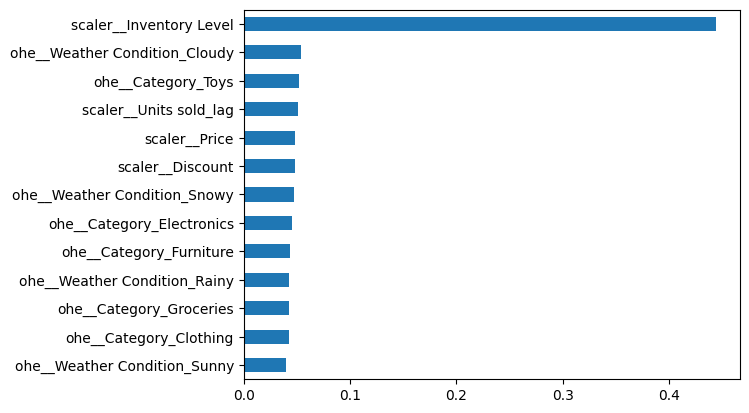

In [13]:
model = xgb.named_steps['xgb']

features = xgb.named_steps['preprocess'].get_feature_names_out()

feat_im = pd.Series(model.feature_importances_, index = features).sort_values(ascending = True)

feat_im.plot(kind= 'barh')

plt.show()

In [14]:
df['Units Sold'].describe()

count    73100.000000
mean       136.464870
std        108.919406
min          0.000000
25%         49.000000
50%        107.000000
75%        203.000000
max        499.000000
Name: Units Sold, dtype: float64